The purpose of the notebook is to train a graph network for predicting the shortest path between two nodes in a graph.

The network is trained to label the nodes and the edges of the shortest path, given the start and the end nodes.

#### Geographical thresholded graph

The geographical threshold graph model places n nodes uniformly at random in a rectangular domain. Each node u is assigned a weight $w_u$. Two nodes u and v are joined by an edge if

$$
w_u+w_v\gt \theta \ r^{\alpha}
$$

where r is the Euclidean distance between u and v and $\theta$, $\alpha$ are parameters.


In [105]:
import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import random as rand

import pprint as pp
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.


def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  #intertools.tee returns two iterable 
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def set_diff(seq0, seq1):
  """Return the set difference between 2 sequences as a list."""
  return list(set(seq0) - set(seq1))

def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

def get_node_dict(graph, attr):
  """Return a `dict` of node:attribute pairs from a graph."""
  return {k: v[attr] for k, v in graph.nodes.items()}

def generate_graph(rand,
                   num_nodes_min_max,
                   dimensions=2,
                   theta=1000.0,
                   rate=1.0):
  """Creates a connected graph.

  The graphs are geographic threshold graphs, but with added edges via a
  minimum spanning tree algorithm, to ensure all nodes are connected.

  Args:
    rand: A random seed for the graph generator. Default= None.
    num_nodes_min_max: A sequence [lower, upper) number of nodes per graph.
    dimensions: (optional) An `int` number of dimensions for the positions.
      Default= 2.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Large values (1000+) make mostly trees. Try
      20-60 for good non-trees. Default=1000.0.
    rate: (optional) A rate parameter for the node weight exponential sampling
      distribution. Default= 1.0.

  Returns:
    The graph.
  """
  # Sample num_nodes.
  num_nodes = rand.randint(*num_nodes_min_max)

  # Create geographic threshold graph.
  #pos_array returns the position of the node in the rectangular domain
  pos_array = rand.uniform(size=(num_nodes, dimensions))
  #pos contains the node and the position in the rectangular domain
  pos = dict(enumerate(pos_array))
  #weight contains the node and the weight sampled from an exponential distribution
  weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))

  geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

  # Create minimum spanning tree across geo_graph's nodes.
  distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
  i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
  weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
  mst_graph = nx.Graph()
  mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
  mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
  
  # Put geo_graph's node attributes into the mst_graph.
  for i in mst_graph.nodes():
    mst_graph.nodes[i].update(geo_graph.nodes[i])

  # Compose the graphs.
  combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
  # Put all distance weights into edge attributes.
  for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])
  return combined_graph, mst_graph, geo_graph


In [3]:
rand = np.random.RandomState(seed=1)

In [4]:
pos_array = rand.uniform(size=(10, 2))

In [5]:
pos_array

array([[4.17022005e-01, 7.20324493e-01],
       [1.14374817e-04, 3.02332573e-01],
       [1.46755891e-01, 9.23385948e-02],
       [1.86260211e-01, 3.45560727e-01],
       [3.96767474e-01, 5.38816734e-01],
       [4.19194514e-01, 6.85219500e-01],
       [2.04452250e-01, 8.78117436e-01],
       [2.73875932e-02, 6.70467510e-01],
       [4.17304802e-01, 5.58689828e-01],
       [1.40386939e-01, 1.98101489e-01]])

In [13]:
#dictinary containing the positions of all the nodes
pos = dict(enumerate(pos_array))

In [7]:
pos

{0: array([0.417022  , 0.72032449]),
 1: array([1.14374817e-04, 3.02332573e-01]),
 2: array([0.14675589, 0.09233859]),
 3: array([0.18626021, 0.34556073]),
 4: array([0.39676747, 0.53881673]),
 5: array([0.41919451, 0.6852195 ]),
 6: array([0.20445225, 0.87811744]),
 7: array([0.02738759, 0.67046751]),
 8: array([0.4173048 , 0.55868983]),
 9: array([0.14038694, 0.19810149])}

In [10]:
#dictionaru containing the weights of the nodes
weight = dict(enumerate(rand.exponential(1, size=10)))

In [11]:
weight

{0: 0.10352534930954074,
 1: 0.5466386995248671,
 2: 3.167458879200206,
 3: 0.7617800132393983,
 4: 1.1772565948999085,
 5: 0.37908947016968575,
 6: 1.1599588780254495,
 7: 1.7995437194267623,
 8: 0.018457575175565604,
 9: 1.386871787578335}

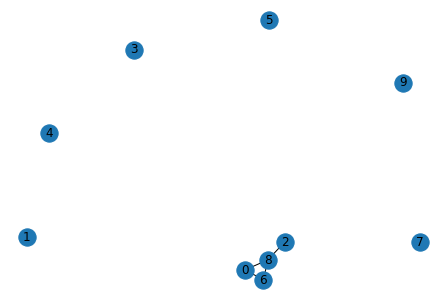

In [40]:
G = nx.geographical_threshold_graph(10, 50)
nx.draw(G,with_labels=True)

In [17]:
#pairwise distance between the points
spatial.distance.pdist(pos_array)

array([0.59036363, 0.68367394, 0.44011236, 0.18263437, 0.03517215,
       0.2647348 , 0.39281127, 0.16163491, 0.59096855, 0.25612732,
       0.19109931, 0.46179913, 0.56765356, 0.61096823, 0.36914382,
       0.48965998, 0.17475844, 0.25628507, 0.51171136, 0.65248032,
       0.78789419, 0.5903235 , 0.53914765, 0.10595449, 0.28576422,
       0.41185734, 0.53286734, 0.36166964, 0.31433361, 0.15442987,
       0.14811057, 0.39001296, 0.39213955, 0.02857834, 0.42640105,
       0.28865872, 0.39208454, 0.12654378, 0.56126431, 0.27289262,
       0.3838492 , 0.68302712, 0.40562258, 0.48569384, 0.45465091])

In [14]:
distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))

In [16]:
#return the distance between one node and all the others
distances

array([[0.        , 0.59036363, 0.68367394, 0.44011236, 0.18263437,
        0.03517215, 0.2647348 , 0.39281127, 0.16163491, 0.59096855],
       [0.59036363, 0.        , 0.25612732, 0.19109931, 0.46179913,
        0.56765356, 0.61096823, 0.36914382, 0.48965998, 0.17475844],
       [0.68367394, 0.25612732, 0.        , 0.25628507, 0.51171136,
        0.65248032, 0.78789419, 0.5903235 , 0.53914765, 0.10595449],
       [0.44011236, 0.19109931, 0.25628507, 0.        , 0.28576422,
        0.41185734, 0.53286734, 0.36166964, 0.31433361, 0.15442987],
       [0.18263437, 0.46179913, 0.51171136, 0.28576422, 0.        ,
        0.14811057, 0.39001296, 0.39213955, 0.02857834, 0.42640105],
       [0.03517215, 0.56765356, 0.65248032, 0.41185734, 0.14811057,
        0.        , 0.28865872, 0.39208454, 0.12654378, 0.56126431],
       [0.2647348 , 0.61096823, 0.78789419, 0.53286734, 0.39001296,
        0.28865872, 0.        , 0.27289262, 0.3838492 , 0.68302712],
       [0.39281127, 0.36914382, 0.5903235

In [18]:
 i_, j_ = np.meshgrid(range(10), range(10), indexing="ij")

In [19]:
i_.

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [20]:
j_

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [22]:
#return a copy 
# if we modify it the original array will not be modified 
i_.flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [23]:
#return a view 
# if we modify it al the original array will be modified
# this one is faster since no menory is copied
i_.ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [24]:
weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
#returns a list of tuples (position_1, position_j,distance)

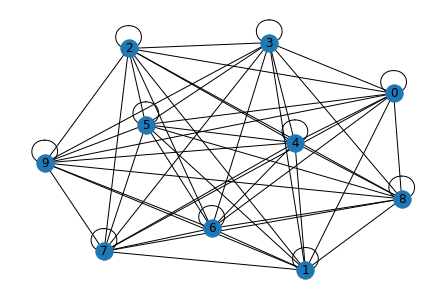

In [37]:
#complete graph because we add all possible combinations of nodes with edge value equal to 
#their distance
mst_graph = nx.Graph()
mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
nx.draw(mst_graph,with_labels=True)

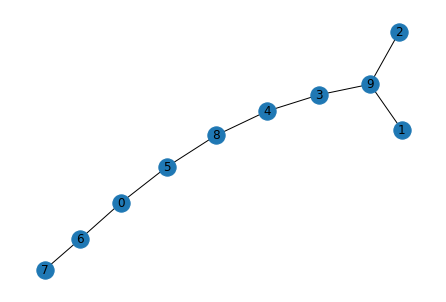

In [38]:
# this one return the minimum spanning tree ,
# a minimum spanning tree is a subgraph of the graph with the minumum sum of the edge weights
mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
nx.draw(mst_graph,with_labels=True)


In [39]:
mst_graph.edges().data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447})])

In [49]:
# union of all graphs , unions of the node sets and edge sets
# combine minumum spanning tree with geographical thresholded graph to produce
# a connected graph  
combined_graph = nx.compose_all((mst_graph, G.copy()))

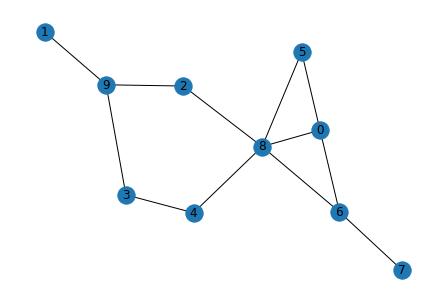

In [51]:
nx.draw(combined_graph,with_labels=True)

In [54]:
combined_graph.edges.data()
# all the edges present in geo_graph have no value ({}) all the others 
# have the value of the distance present in the mst_graph
# in general if a graph attribute is present in multiple graphs, then the value from the last graph
# in the list with that attribute is used

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (0, 8, {}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (2, 8, {}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447}), (6, 8, {})])

In [55]:
# the empty values are filled with the distances present in the mst_graph

for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])

In [56]:
combined_graph.edges.data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (0, 8, {'distance': 0.16163491238906158}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (2, 8, {'distance': 0.5391476483236425}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447}), (6, 8, {'distance': 0.38384919679619406})])

In [57]:
def add_shortest_path(rand, graph, min_length=1):
  """Samples a shortest path from A to B and adds attributes to indicate it.

  Args:
    rand: A random seed for the graph generator. Default= None.
    graph: A `nx.Graph`.
    min_length: (optional) An `int` minimum number of edges in the shortest
      path. Default= 1.

  Returns:
    The `nx.DiGraph` with the shortest path added.

  Raises:
    ValueError: All shortest paths are below the minimum length
  """
  # Map from node pairs to the length of their shortest path.
  pair_to_length_dict = {}
  # pair_to_length_dict={(1,3):4,(1,9):6,,,,}

  try:
    # This is for compatibility with older networkx.
    lengths = nx.all_pairs_shortest_path_length(graph).items()
  except AttributeError:
    # This is for compatibility with newer networkx.
    lengths = list(nx.all_pairs_shortest_path_length(graph))
    
  for x, yy in lengths:
    for y, l in yy.items():
      if l >= min_length:
        pair_to_length_dict[x, y] = l
  if max(pair_to_length_dict.values()) < min_length:
    raise ValueError("All shortest paths are below the minimum length")
  
  # The node pairs which exceed the minimum length.
  # with list only the keys are returned 
  node_pairs = list(pair_to_length_dict)

  # Computes probabilities per pair, to enforce uniform sampling of each
  # shortest path lengths.
  # The counts of pairs per length.
  
  # counts contain the values of the shortest paths and how many times they appear 
  # in the dictionary
  counts = collections.Counter(pair_to_length_dict.values())
  prob_per_length = 1.0 / len(counts)
  probabilities = [
      prob_per_length / counts[pair_to_length_dict[x]] for x in node_pairs
  ]

  # Choose the start and end points.
  i = rand.choice(len(node_pairs), p=probabilities)
  start, end = node_pairs[i]

  #return a list of nodes in the shortest path from the source to the target
  path = nx.shortest_path(
      graph, source=start, target=end, weight=DISTANCE_WEIGHT_NAME)

  # Creates a directed graph, to store the directed path from start to end.
  # creates a deep copy of the graph 
  # instead DiGraph(graph) creates a shallow copy of the graph
  digraph = graph.to_directed()

  # Add the "start", "end", and "solution" attributes to the nodes and edges.
  digraph.add_node(start, start=True)
  digraph.add_node(end, end=True)
  digraph.add_nodes_from(set_diff(digraph.nodes(), [start]), start=False)
  digraph.add_nodes_from(set_diff(digraph.nodes(), [end]), end=False)
  digraph.add_nodes_from(set_diff(digraph.nodes(), path), solution=False)
  digraph.add_nodes_from(path, solution=True)
  path_edges = list(pairwise(path))
  digraph.add_edges_from(set_diff(digraph.edges(), path_edges), solution=False)
  digraph.add_edges_from(path_edges, solution=True)

  return digraph

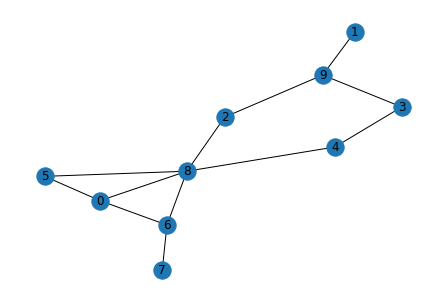

In [73]:
nx.draw(combined_graph,with_labels=True)

In [72]:
list(nx.all_pairs_shortest_path_length(combined_graph))
# computes the shostest path lenghts between all the nodes in G
# returns a list of (source, dictionary) where the dctionary
# is keyed by target and shortest path lenghts as the key value
 

[(0, {0: 0, 8: 1, 5: 1, 6: 1, 2: 2, 4: 2, 7: 2, 9: 3, 3: 3, 1: 4}),
 (1, {1: 0, 9: 1, 2: 2, 3: 2, 8: 3, 4: 3, 0: 4, 5: 4, 6: 4, 7: 5}),
 (2, {2: 0, 8: 1, 9: 1, 0: 2, 1: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3}),
 (3, {3: 0, 9: 1, 4: 1, 8: 2, 1: 2, 2: 2, 0: 3, 5: 3, 6: 3, 7: 4}),
 (4, {4: 0, 8: 1, 3: 1, 0: 2, 2: 2, 5: 2, 6: 2, 9: 2, 1: 3, 7: 3}),
 (5, {5: 0, 0: 1, 8: 1, 2: 2, 4: 2, 6: 2, 3: 3, 7: 3, 9: 3, 1: 4}),
 (6, {6: 0, 0: 1, 8: 1, 7: 1, 2: 2, 4: 2, 5: 2, 9: 3, 3: 3, 1: 4}),
 (7, {7: 0, 6: 1, 0: 2, 8: 2, 2: 3, 4: 3, 5: 3, 9: 4, 3: 4, 1: 5}),
 (8, {8: 0, 0: 1, 2: 1, 4: 1, 5: 1, 6: 1, 3: 2, 7: 2, 9: 2, 1: 3}),
 (9, {9: 0, 1: 1, 2: 1, 3: 1, 8: 2, 4: 2, 0: 3, 5: 3, 6: 3, 7: 4})]

In [80]:
nx.shortest_path(combined_graph,0,3,weight=DISTANCE_WEIGHT_NAME)
#returns the list of the nodes in the shortest path between two nodes

[0, 8, 4, 3]

In [81]:
rand = np.random.RandomState(seed=SEED)
combined_graph_short=add_shortest_path(rand,combined_graph)

In [85]:
combined_graph.nodes.data()

NodeDataView({0: {'weight': 1.1808365414059072, 'pos': [0.6477900064149638, 0.5696485123139942]}, 1: {'weight': 0.9099203367359953, 'pos': [0.23154436217968377, 0.6462901421071049]}, 2: {'weight': 1.1152960532860092, 'pos': [0.5372641984488923, 0.3288746366849249]}, 3: {'weight': 0.49467001545848893, 'pos': [0.6483505783917282, 0.9936769632498018]}, 4: {'weight': 1.5302959017049962, 'pos': [0.19206525955551446, 0.2297846890824341]}, 5: {'weight': 0.21186909484803854, 'pos': [0.10784558422573176, 0.8331108395042138]}, 6: {'weight': 0.17442275626329629, 'pos': [0.6466384010851952, 0.5864112856530294]}, 7: {'weight': 1.6126198407027885, 'pos': [0.8132448673663146, 0.3378690857703849]}, 8: {'weight': 0.8225261860790685, 'pos': [0.61332978410049, 0.4983403287517144]}, 9: {'weight': 0.9172688822572008, 'pos': [0.4321658007302047, 0.7948732510809783]}})

In [86]:
combined_graph_short.nodes.data()
# contains the same nodes but with more attributes
# 'start' if the node is the starting node of the shortest path
# 'end' if the node is the ending node of the shortest path
# 'solution' if the node belongs to the shortest path 

NodeDataView({0: {'weight': 1.1808365414059072, 'pos': [0.6477900064149638, 0.5696485123139942], 'start': False, 'end': False, 'solution': False}, 1: {'weight': 0.9099203367359953, 'pos': [0.23154436217968377, 0.6462901421071049], 'start': False, 'end': False, 'solution': False}, 2: {'weight': 1.1152960532860092, 'pos': [0.5372641984488923, 0.3288746366849249], 'start': False, 'end': False, 'solution': False}, 3: {'weight': 0.49467001545848893, 'pos': [0.6483505783917282, 0.9936769632498018], 'start': True, 'end': False, 'solution': True}, 4: {'weight': 1.5302959017049962, 'pos': [0.19206525955551446, 0.2297846890824341], 'start': False, 'end': False, 'solution': True}, 5: {'weight': 0.21186909484803854, 'pos': [0.10784558422573176, 0.8331108395042138], 'start': False, 'end': False, 'solution': False}, 6: {'weight': 0.17442275626329629, 'pos': [0.6466384010851952, 0.5864112856530294], 'start': False, 'end': False, 'solution': True}, 7: {'weight': 1.6126198407027885, 'pos': [0.813244867

In [87]:
combined_graph.edges.data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (0, 8, {'distance': 0.16163491238906158}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (2, 8, {'distance': 0.5391476483236425}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447}), (6, 8, {'distance': 0.38384919679619406})])

In [88]:
combined_graph_short.edges.data()
#'solution' if the edge belongs to the shortest path

OutEdgeDataView([(0, 5, {'distance': 0.03517215283597537, 'solution': False}), (0, 6, {'distance': 0.2647347985681034, 'solution': False}), (0, 8, {'distance': 0.16163491238906158, 'solution': False}), (1, 9, {'distance': 0.17475843592283455, 'solution': False}), (2, 9, {'distance': 0.10595448724107487, 'solution': False}), (2, 8, {'distance': 0.5391476483236425, 'solution': False}), (3, 9, {'distance': 0.15442986762597377, 'solution': False}), (3, 4, {'distance': 0.2857642243880516, 'solution': True}), (4, 3, {'distance': 0.2857642243880516, 'solution': False}), (4, 8, {'distance': 0.028578343718642082, 'solution': True}), (5, 0, {'distance': 0.03517215283597537, 'solution': False}), (5, 8, {'distance': 0.12654378252450532, 'solution': False}), (6, 0, {'distance': 0.2647347985681034, 'solution': False}), (6, 7, {'distance': 0.2728926243954447, 'solution': True}), (6, 8, {'distance': 0.38384919679619406, 'solution': False}), (7, 6, {'distance': 0.2728926243954447, 'solution': False}), 

In [162]:
def graph_to_input_target(graph):
  """Returns 2 graphs with input and target feature vectors for training.

  Args:
    graph: An `nx.DiGraph` instance.

  Returns:
    The input `nx.DiGraph` instance.
    The target `nx.DiGraph` instance.

  Raises:
    ValueError: unknown node type
  """

  def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

  input_node_fields = ("pos", "weight", "start", "end")
  input_edge_fields = ("distance",)
  target_node_fields = ("solution",)
  target_edge_fields = ("solution",)

  input_graph = graph.copy()
  target_graph = graph.copy()

  solution_length = 0

  for node_index, node_feature in graph.nodes(data=True):

    #in input graph each node has as features the concatenation of its fields 
    input_graph.add_node(
        node_index, features=create_feature(node_feature, input_node_fields))

    #in target graph each node has as features a one hot vector 
    target_node = to_one_hot(
        create_feature(node_feature, target_node_fields).astype(int), 2)[0]
    target_graph.add_node(node_index, features=target_node)

    #keep track of the lenght of the shortest path 
    solution_length += int(node_feature["solution"])
  
  solution_length /= graph.number_of_nodes()
  
  for sender, receiver, features in graph.edges(data=True):
    
    input_graph.add_edge(
        sender, receiver, features=create_feature(features, input_edge_fields))
    
    # in the target graph each edge has as features a one hot vector
    # if it does not belongs to the shortest path 'solution'=False -> [1,0]
    # if it belongs to the shortest path 'solution'=True -> [0,1]
    target_edge = to_one_hot(
        create_feature(features, target_edge_fields).astype(int), 2)[0]
    target_graph.add_edge(sender, receiver, features=target_edge)

  input_graph.graph["features"] = np.array([0.0])
  target_graph.graph["features"] = np.array([solution_length], dtype=float)

  return input_graph, target_graph

In [110]:
def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

input_node_fields = ("pos", "weight", "start", "end")

for i,j in combined_graph_short.nodes(data=True):
    print(i)
    pp.pprint(j)
    print(create_feature(j, input_node_fields))
    break

# features 'pos' ,'weight', 'start' ,'end' are hstacked together

0
{'end': False,
 'pos': [0.6477900064149638, 0.5696485123139942],
 'solution': False,
 'start': False,
 'weight': 1.1808365414059072}
[0.64779001 0.56964851 1.18083654 0.         0.        ]


In [115]:
target_node_fields = ("solution",)

for node_index,node_features in combined_graph_short.nodes(data=True):
    print(node_index)
    pp.pprint(node_features)
    print(create_feature(node_features, target_node_fields))
    print(to_one_hot(create_feature(node_features, target_node_fields).astype(int), 2)[0])
    break


0
{'end': False,
 'pos': [0.6477900064149638, 0.5696485123139942],
 'solution': False,
 'start': False,
 'weight': 1.1808365414059072}
[0.]
[1. 0.]


In [129]:
print(to_one_hot([0],2))
print(to_one_hot([1],2))
print(to_one_hot(1,2))
print(to_one_hot(0,2))
print(to_one_hot(0,3))
print(to_one_hot(1,3))
print(to_one_hot(2,3))

[[1. 0.]]
[[0. 1.]]
[0. 1.]
[1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [163]:
input_graph,target_graph=graph_to_input_target(combined_graph_short)